# Simulating brain circuit stimulation

## Import libraries

For this model, we will be using Numpy and Matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setting constants and characteristics

It is generally good to _initialize_ all of the repeatedly used variables at the beginning--so that's what I will do.

In [5]:
# parameters
a = .02
b = .2
c = -50
d = 2

#constants
c1 = .04
c2 = 5
c3 = 140

#initial membrane voltage
v = -65

# recovery variable
u = b*v

## Apply model to 1 cell

In [11]:
# create time
time = 1000

# create empty membrane voltage vector
membrane_voltage = np.zeros(time)

# create scalar for each time point
I_all = np.zeros(time)

# loop over time
for i in range(time):
    # define input strength at timepoints
    I = -2 if (i > 200) & (i < 400) else 7
    # check action potential
    if v >= 30:
        v = c
        u += d
    #update membrane variables
    v += c1*v**2 + c2*v + c3 - u + I
    u += a*(b*v - u)
    # collects vars
    membrane_voltage[i] = v
    I_all[i] = I
    

## Plotting 1 cell

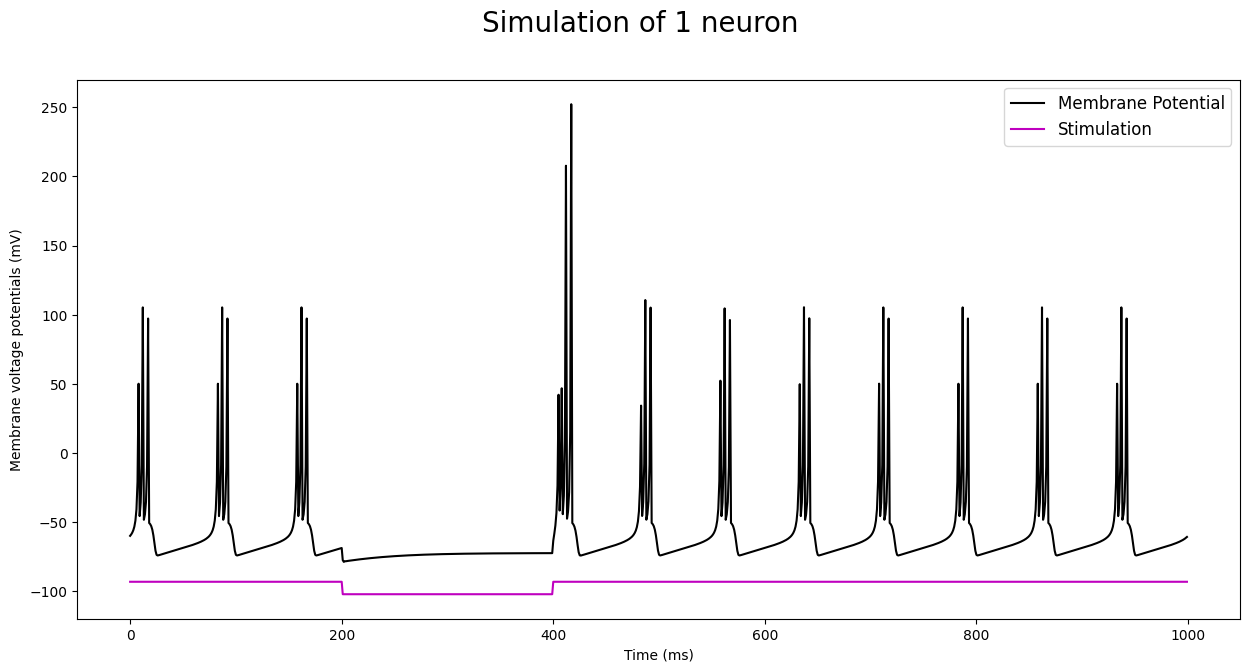

In [50]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(membrane_voltage, 'k' ,label="Membrane Potential")
ax.plot(I_all-100, 'm', label="Stimulation")
fig.suptitle("Simulation of 1 neuron", fontsize=20)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane voltage potentials (mV)')
ax.legend(fontsize=12)
plt.show()

## Parameters for entire circuit (1000 neurons!)

In [18]:
# excitatory cells                          inhibitory cells
Ne = 800;                                   Ni = 200
re = np.random.rand(Ne);                    ri = np.random.rand(Ni) # random int

a = np.hstack((0.02*np.ones(Ne),            0.02 + 0.08*ri))   
b = np.hstack((0.2 * np.ones(Ne),           0.25 - 0.05 *ri))
c = np.hstack((-65 + 15 * re**2,               -65 * np.ones(Ni)))
d = np.hstack((8 - 6 * re**2,                  2 * np.ones(Ni)))

v = -65*np.ones(Ne + Ni) # common across both cell types
u = b*v # common across both cell types

S = np.hstack((0.5*np.random.rand(Ne + Ni, Ne), - np.random.rand(Ne + Ni, Ni)))

## Plotting $S$

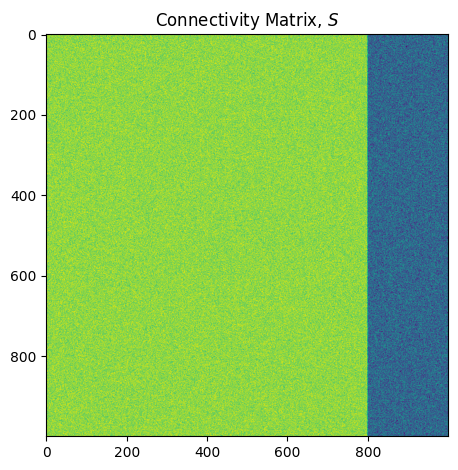

In [40]:
plt.imshow(S)
plt.title("Connectivity Matrix, $S$")
plt.tight_layout()
plt.show()

## Simulating the neural circuit

In [19]:
# create time
time = 5000 # ms

# create firings array
firings = np.array([[], []])

for i in range(time):
    # define I
    I = np.hstack((5*np.random.randn(Ne), 2*np.random.randn(Ni)))
    # check for activity (action potentials)
    fired = np.where(v >= 30)[0] # gives list of indices where v >= 30
    # spike indices and times
    X = np.stack((np.tile(i, len(fired)), fired))
    firings = np.concatenate((firings, X), axis=1)
    # update membrane vars with spikes
    v[fired] = c[fired]
    u[fired] += d[fired]
    # update I with spiking activity
    I += np.sum(S[:, fired], axis=1)
    #update membrane potential
    v += .04*v**2 + 5*v + 140 - u + I
    u += a*(b*v - u)


## Plot circuit firing rate

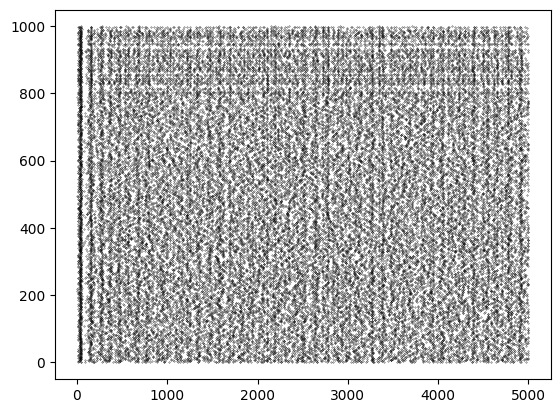

In [23]:
plt.plot(firings[0,:], firings[1,:], 'k.', markersize=0.5)
plt.show()

## Population activity

In [48]:
# initialize
pop_activity = np.zeros(time)

# get average porportion of neurons firing at each time point
for i in range(time):
    pop_activity[i] = np.sum(firings[0,:]==i)/(Ne + Ni)

# spectral analysis
pop_spectral = np.abs(np.fft.fft(pop_activity-np.mean(pop_activity)))**2 # mean centering!
hz = np.linspace(0, 1000/2, int(time/2+1)) # get frequencies

## Plot population activity

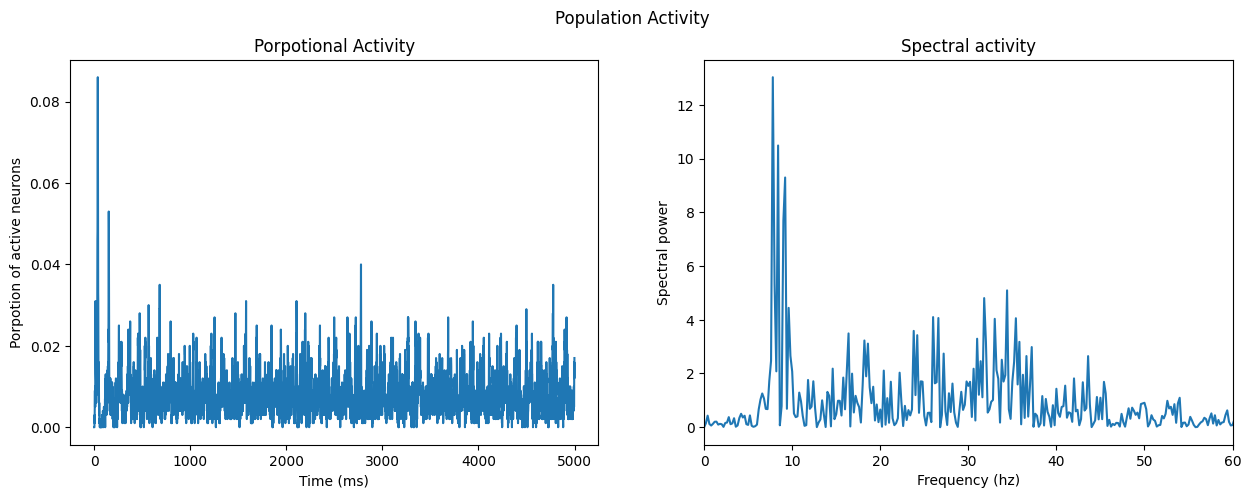

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Population Activity")
ax[0].plot(pop_activity)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Porpotion of active neurons')
ax[0].set_title('Porpotional Activity')

ax[1].plot(hz, pop_spectral[:len(hz)]) # plot only positive
ax[1].set_xlabel('Frequency (hz)')
ax[1].set_ylabel('Spectral power')
ax[1].set_xlim([0, 60])
ax[1].set_title('Spectral activity')

plt.show()


## Creating a module to run experiments

> [neuronsim.py](/neuronsim.py)

## Running Experiments

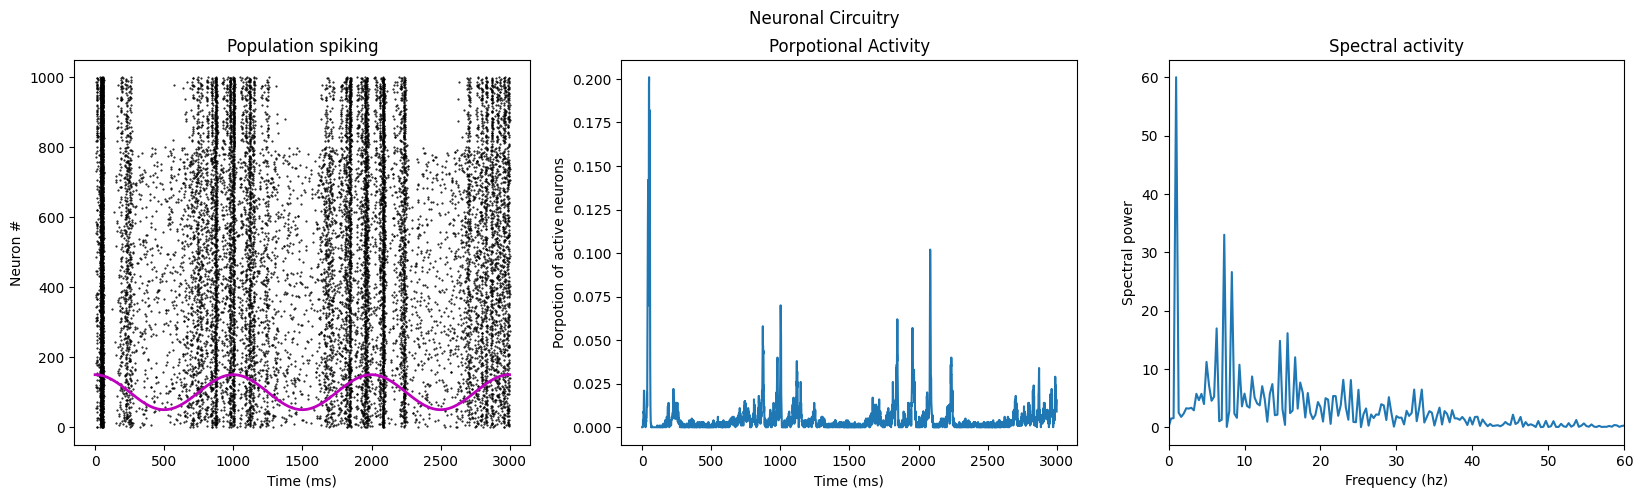

In [10]:
# import the new module
import neuronsim as ns

# create your stimulation
I = np.cos(np.linspace(0, 6*np.pi, 3000))

# simulate stim on the circuit
ans = ns.simCircuit(I)

# plot
ns.plotPopActivity(ans, I)